📊 Startup Analysis & Prediction
Objective
This notebook explores a dataset of startups to uncover key patterns and trends in their categories, funding history, and status (acquired, closed, or still operating).

By leveraging data visualization, feature engineering, and machine learning, we aim to:

Analyze startup trends over time (funding, founding years, industry categories).
Identify success factors that contribute to a startup’s survival or acquisition.
Build a predictive model that estimates the probability of a startup thriving or failing.

In [65]:
#Importations 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
import squarify
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score


In [66]:
df = pd.read_csv("Startup.csv")
print(df.columns)

Index(['category_list', 'funding_total_usd', 'status', 'country_code',
       'funding_rounds', 'founded_at', 'first_funding_at', 'last_funding_at'],
      dtype='object')



### **Columns Overview:**
- **category_list**: Contains the industry sector of the startup.  
- **funding_total_usd**: Contains the total value of funds raised.  
- **status**: Indicates the status of the startup.  
- **country_code**: The country where the startup is established.  
- **funding_rounds**: The number of funding rounds.  
- **founded_at**: The date of creation.  
- **first_funding_at**: The date of the first funding round.  
- **last_funding_at**: The date of the last funding round.  

We will now process these columns to ensure they are correctly formatted and usable.

The **category_list** column contains a large number of categories, with multiple categories assigned to some startups. To ensure a coherent analysis, we will:  

1. **Reduce the number of categories per startup to just one.**  
2. **Simplify and consolidate categories to reduce overall category count.**  

This will allow for a clearer and more structured analysis of the data. Let's proceed with these modifications.

In [67]:


# We create a row for each category of every Startup in order to count the number of occurrences of each category.
df_exploded = df.assign(category_list=df["category_list"].str.split("|")).explode("category_list")

# We fill the missed information
df_exploded["category_list"] = df_exploded["category_list"].fillna("unknown").astype(str)

df["category_list"] = df["category_list"].fillna("unknown").astype(str)

category_counts = df_exploded["category_list"].value_counts()

# We only keep the most represented category for each StartuP
df["category_list"] = df["category_list"].apply(
    lambda x: max(x.split("|"), key=lambda cat: category_counts.get(cat, 0))
)

# Each Startup that had have a category that is represented less than 100 times in the dataset goes into an "Other" section
threshold = 100

category_counts = df["category_list"].value_counts()

df["category_list"] = df["category_list"].apply(lambda x: x if category_counts[x] >= threshold else "Other")

print("#of categories" , df["category_list"].nunique())

print(df["category_list"].value_counts())

#of categories 66
category_list
Software           8768
Mobile             4989
Other              4943
Biotechnology      4544
E-Commerce         3769
                   ... 
Cloud Computing     121
Nonprofits          118
Nanotechnology      111
Digital Media       103
Recruiting          103
Name: count, Length: 66, dtype: int64


We now have 66 distinct categories, each containing at least 100 startups, making this column fully suitable for analysis and modeling.

All other columns are already cleaned and ready for use.

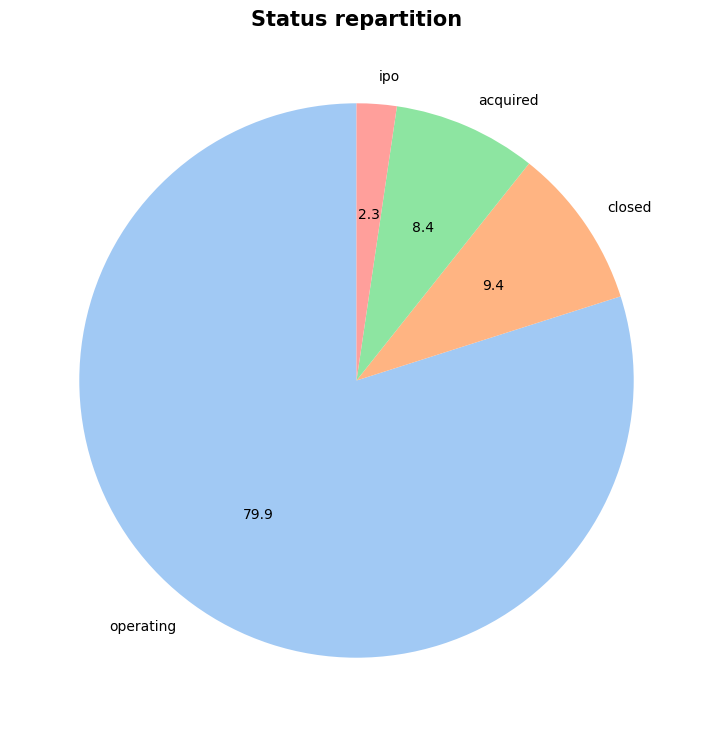

In [68]:
# Calculate the frequency of values in the "status" column
status_count = df["status"].value_counts()
colors = sns.color_palette("pastel", n_colors=len(status_count))
# Plot the pie chart with labels and percentages
plt.figure(figsize=(15, 9))
plt.pie(status_count, labels=status_count.index, autopct="%1.1f", startangle=90, colors=colors)
plt.title("Status repartition", fontsize = 15, fontweight = "bold")

plt.show()

High Operational Rate (90.6%) – A Sign of Bias?

More than 90% of startups in this dataset are still operational, which seems unusually high given real-world startup failure rates.
The data set seems to have a huge survivorship bias

Let's begin by exploring the distribution of categories.

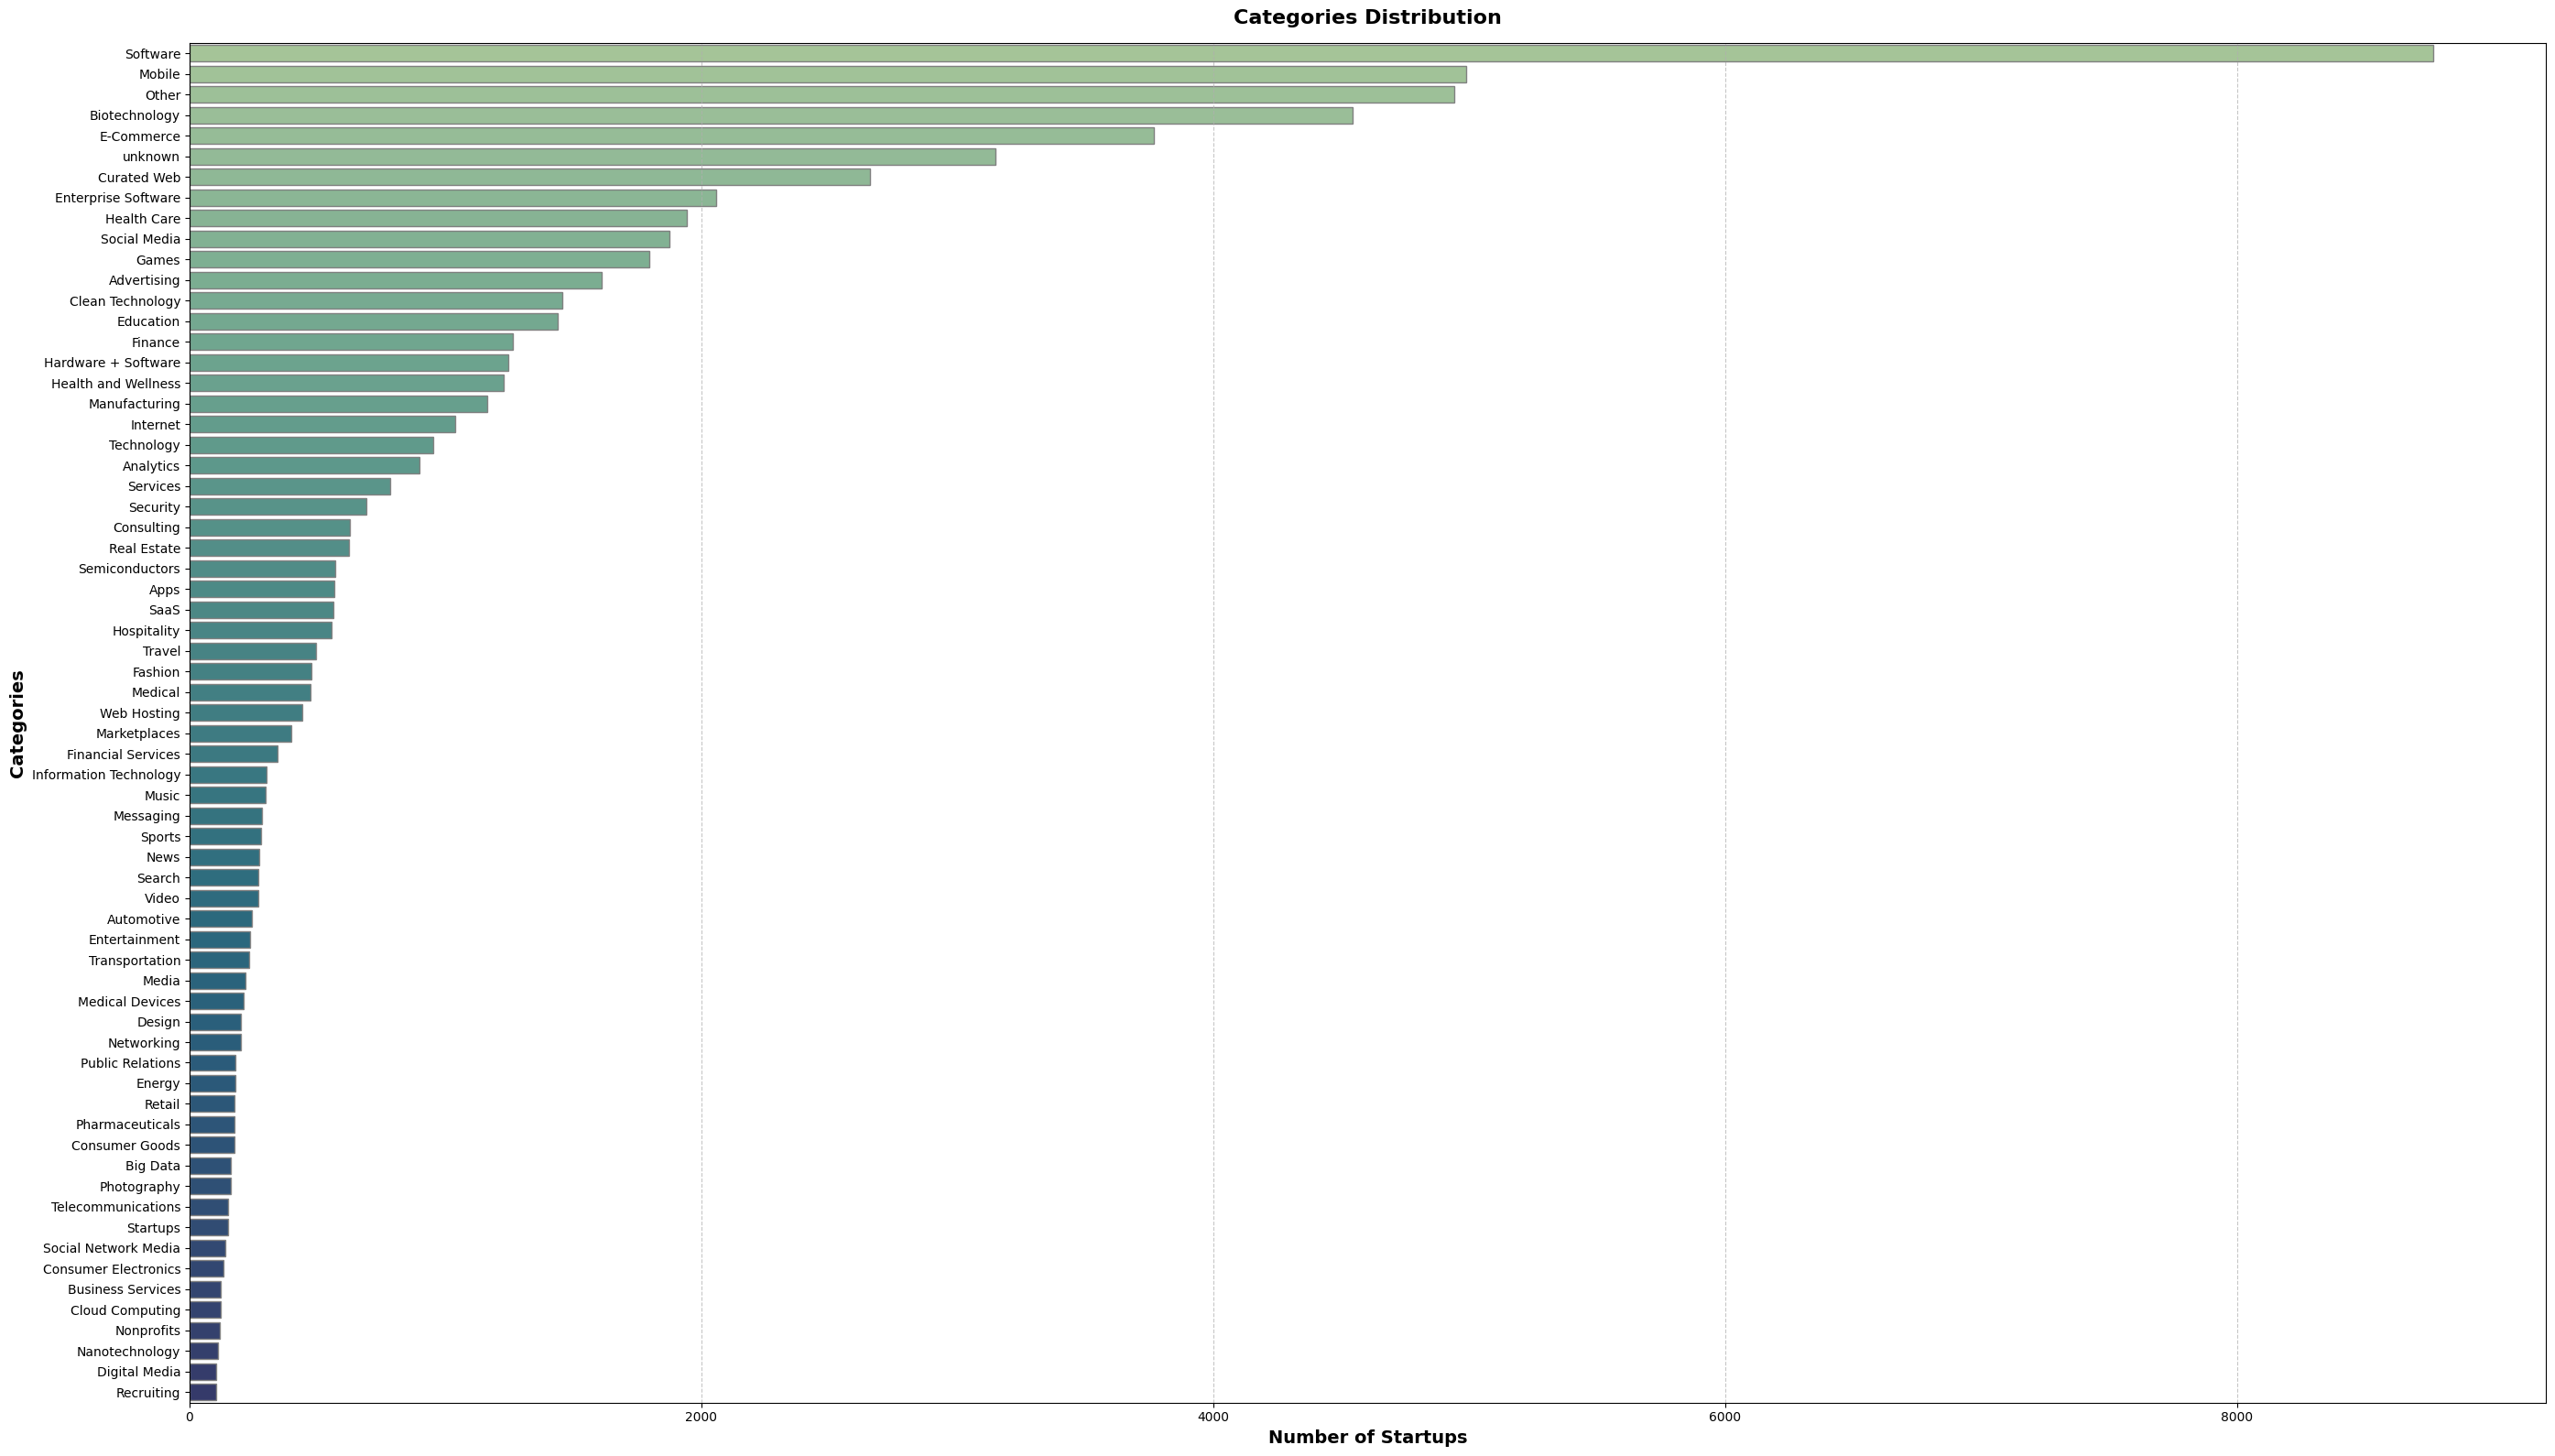

In [69]:


# Calculate category counts
category_counts = df['category_list'].value_counts()

# Set figure size
plt.figure(figsize=(28, 16))

# Create a horizontal barplot with hue
sns.barplot(
    x=category_counts.values, 
    y=category_counts.index, 
    hue=category_counts.index,  # Assign y variable to hue
    palette="crest", 
    edgecolor="grey",
    legend=False  # Disable legend since hue is just for color mapping
)

# Set labels and title
plt.xlabel("Number of Startups", fontsize=14, fontweight="bold")
plt.ylabel("Categories", fontsize=14, fontweight="bold")
plt.title("Categories Distribution", fontsize=16, fontweight="bold", pad=15)

# Grid lines for better readability
plt.grid(axis='x', linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


This bar chart represents the distribution of startups across various industry categories in the dataset. Here are some key insights:

1️⃣ Dominance of the "Software" Category

The Software category has the highest representation, significantly outpacing all other categories.
This suggests that a large portion of startups in the dataset are technology-driven, likely offering software solutions, SaaS products, or enterprise applications.

2️⃣ Disparity Between Leading and Small Categories

The distribution follows a power law, where a few categories (Software, Mobile, E-Commerce) dominate, while many others have far fewer startups.
This is a typical pattern in startup ecosystems, where a few sectors attract most of the funding and activity.

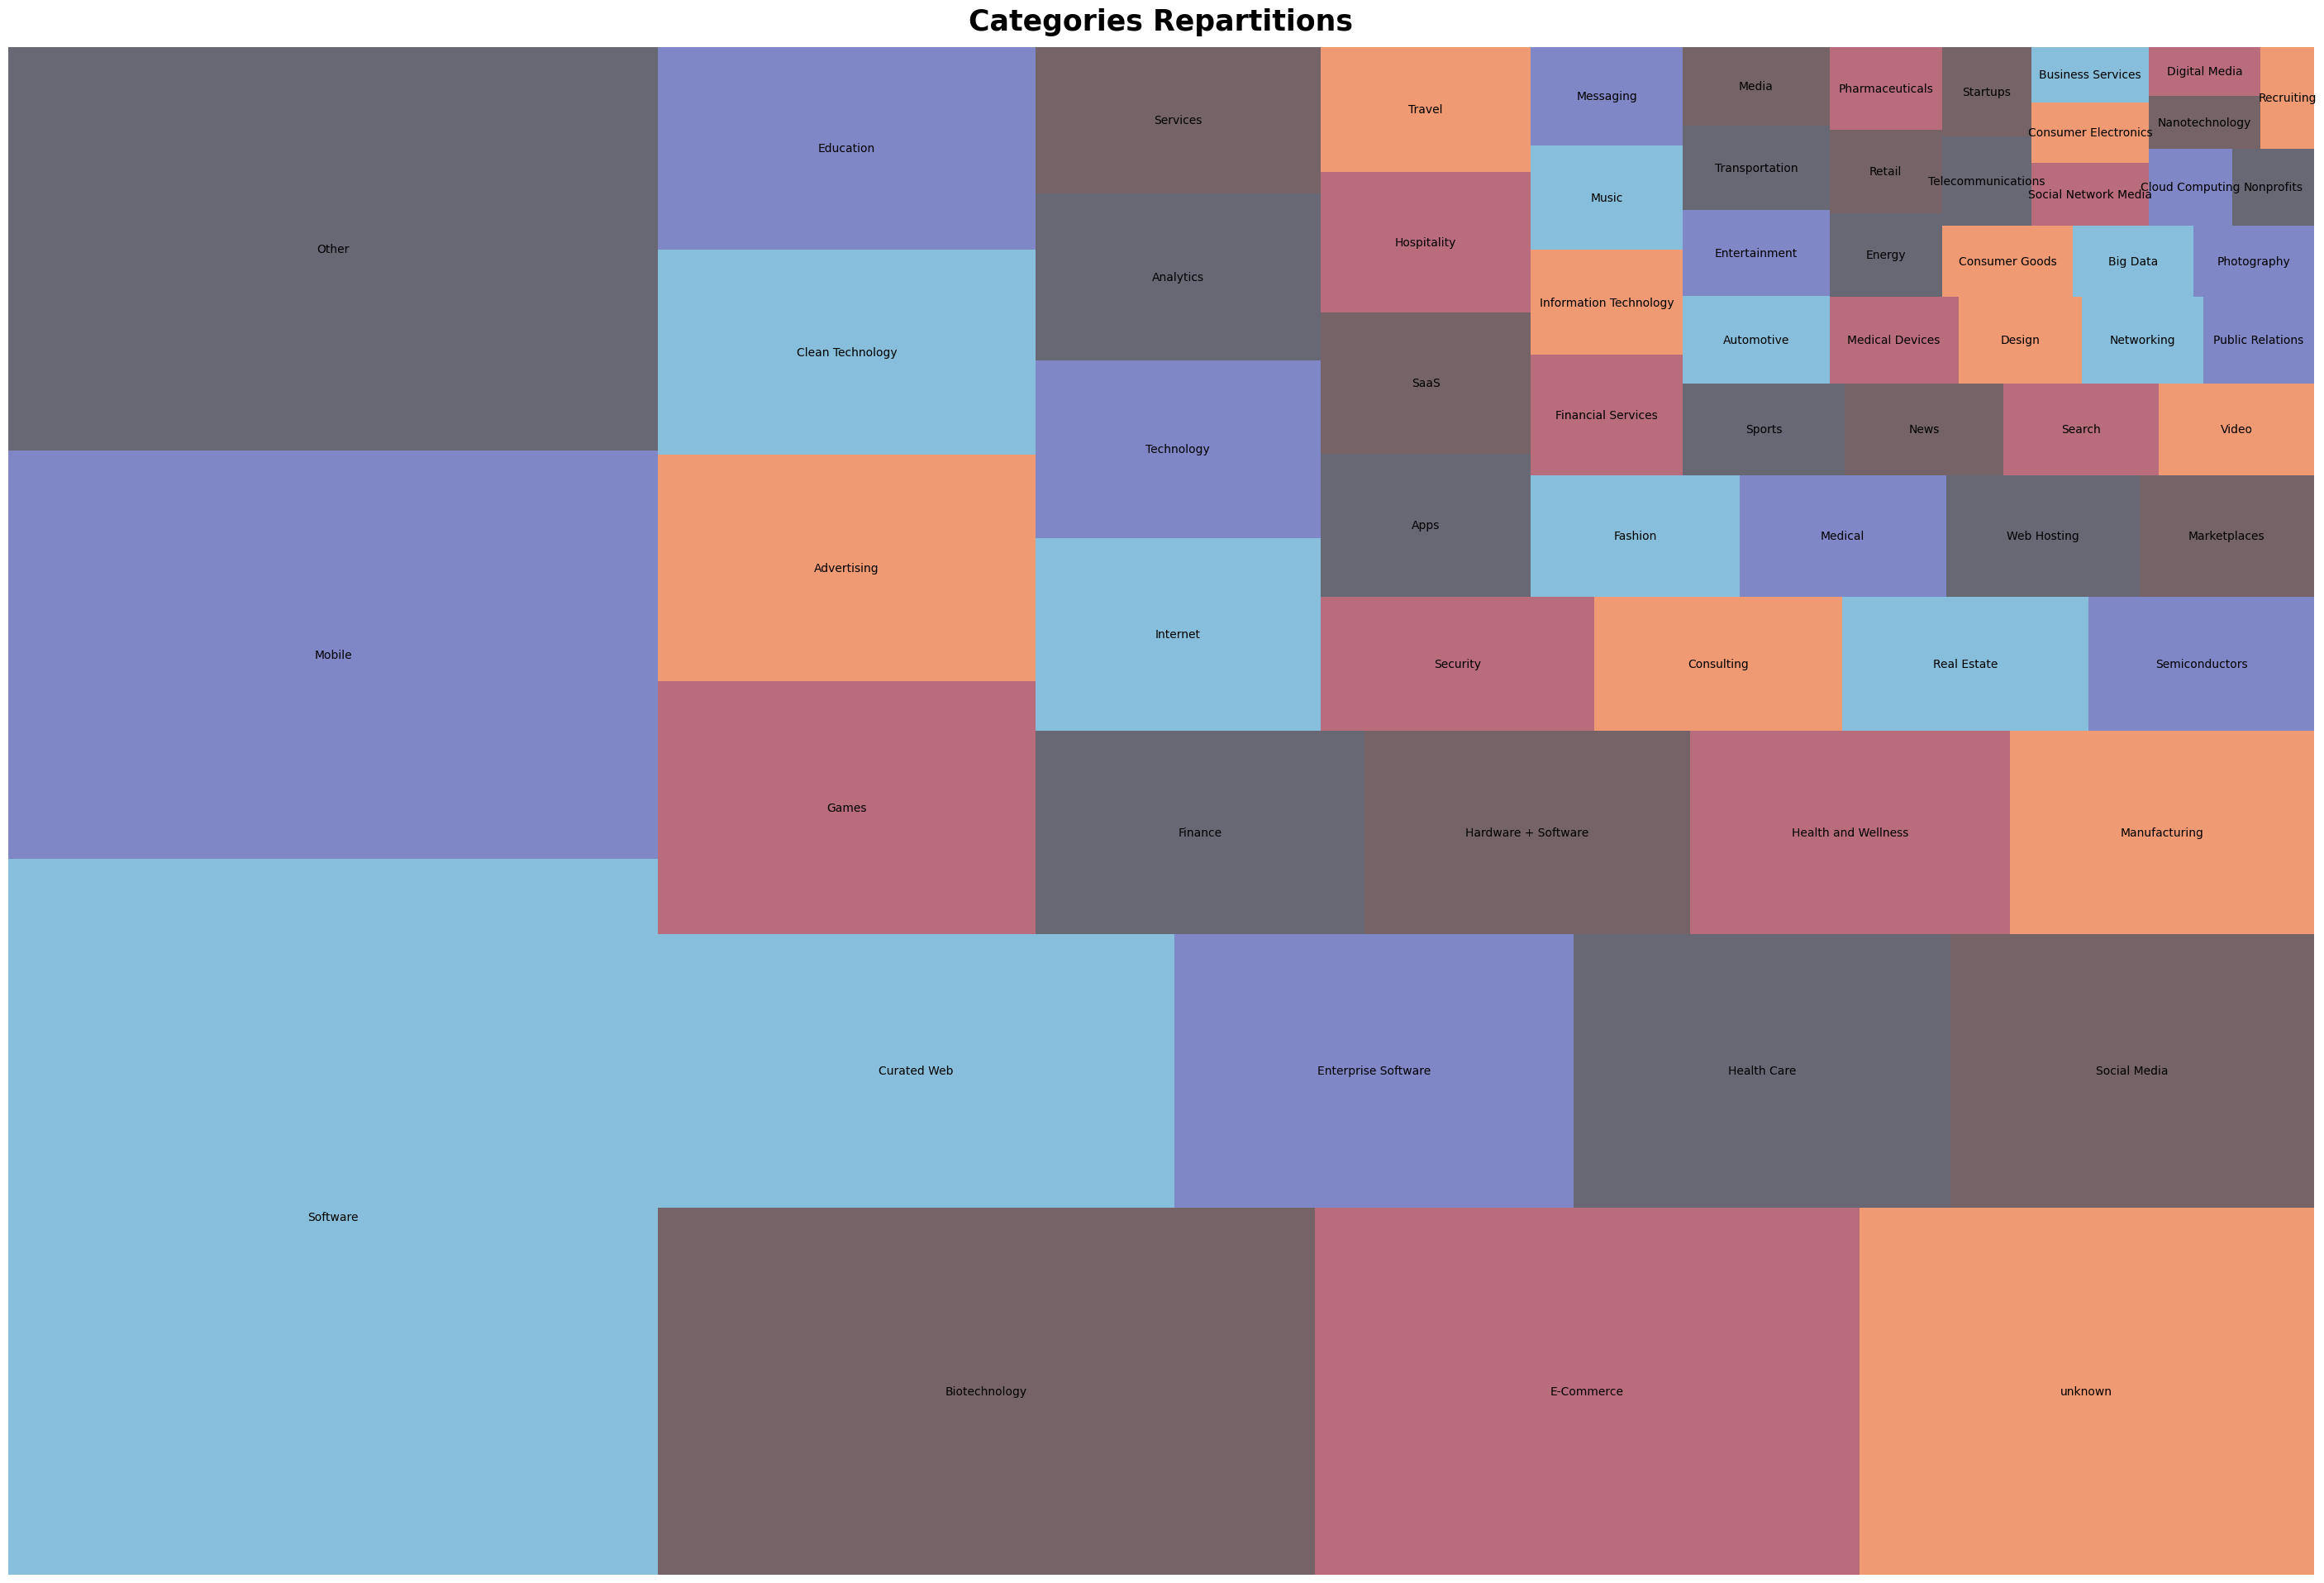

In [70]:
colors = sns.color_palette("icefire")


plt.figure(figsize=(36, 24))
squarify.plot(sizes=category_counts, label=category_counts.index, alpha=0.7, color = colors)
plt.axis('off')
plt.title("Categories Repartitions",fontsize=25, fontweight="bold", pad=15)
plt.show()

The same data is now presented in a different format for better visualization and interpretation.

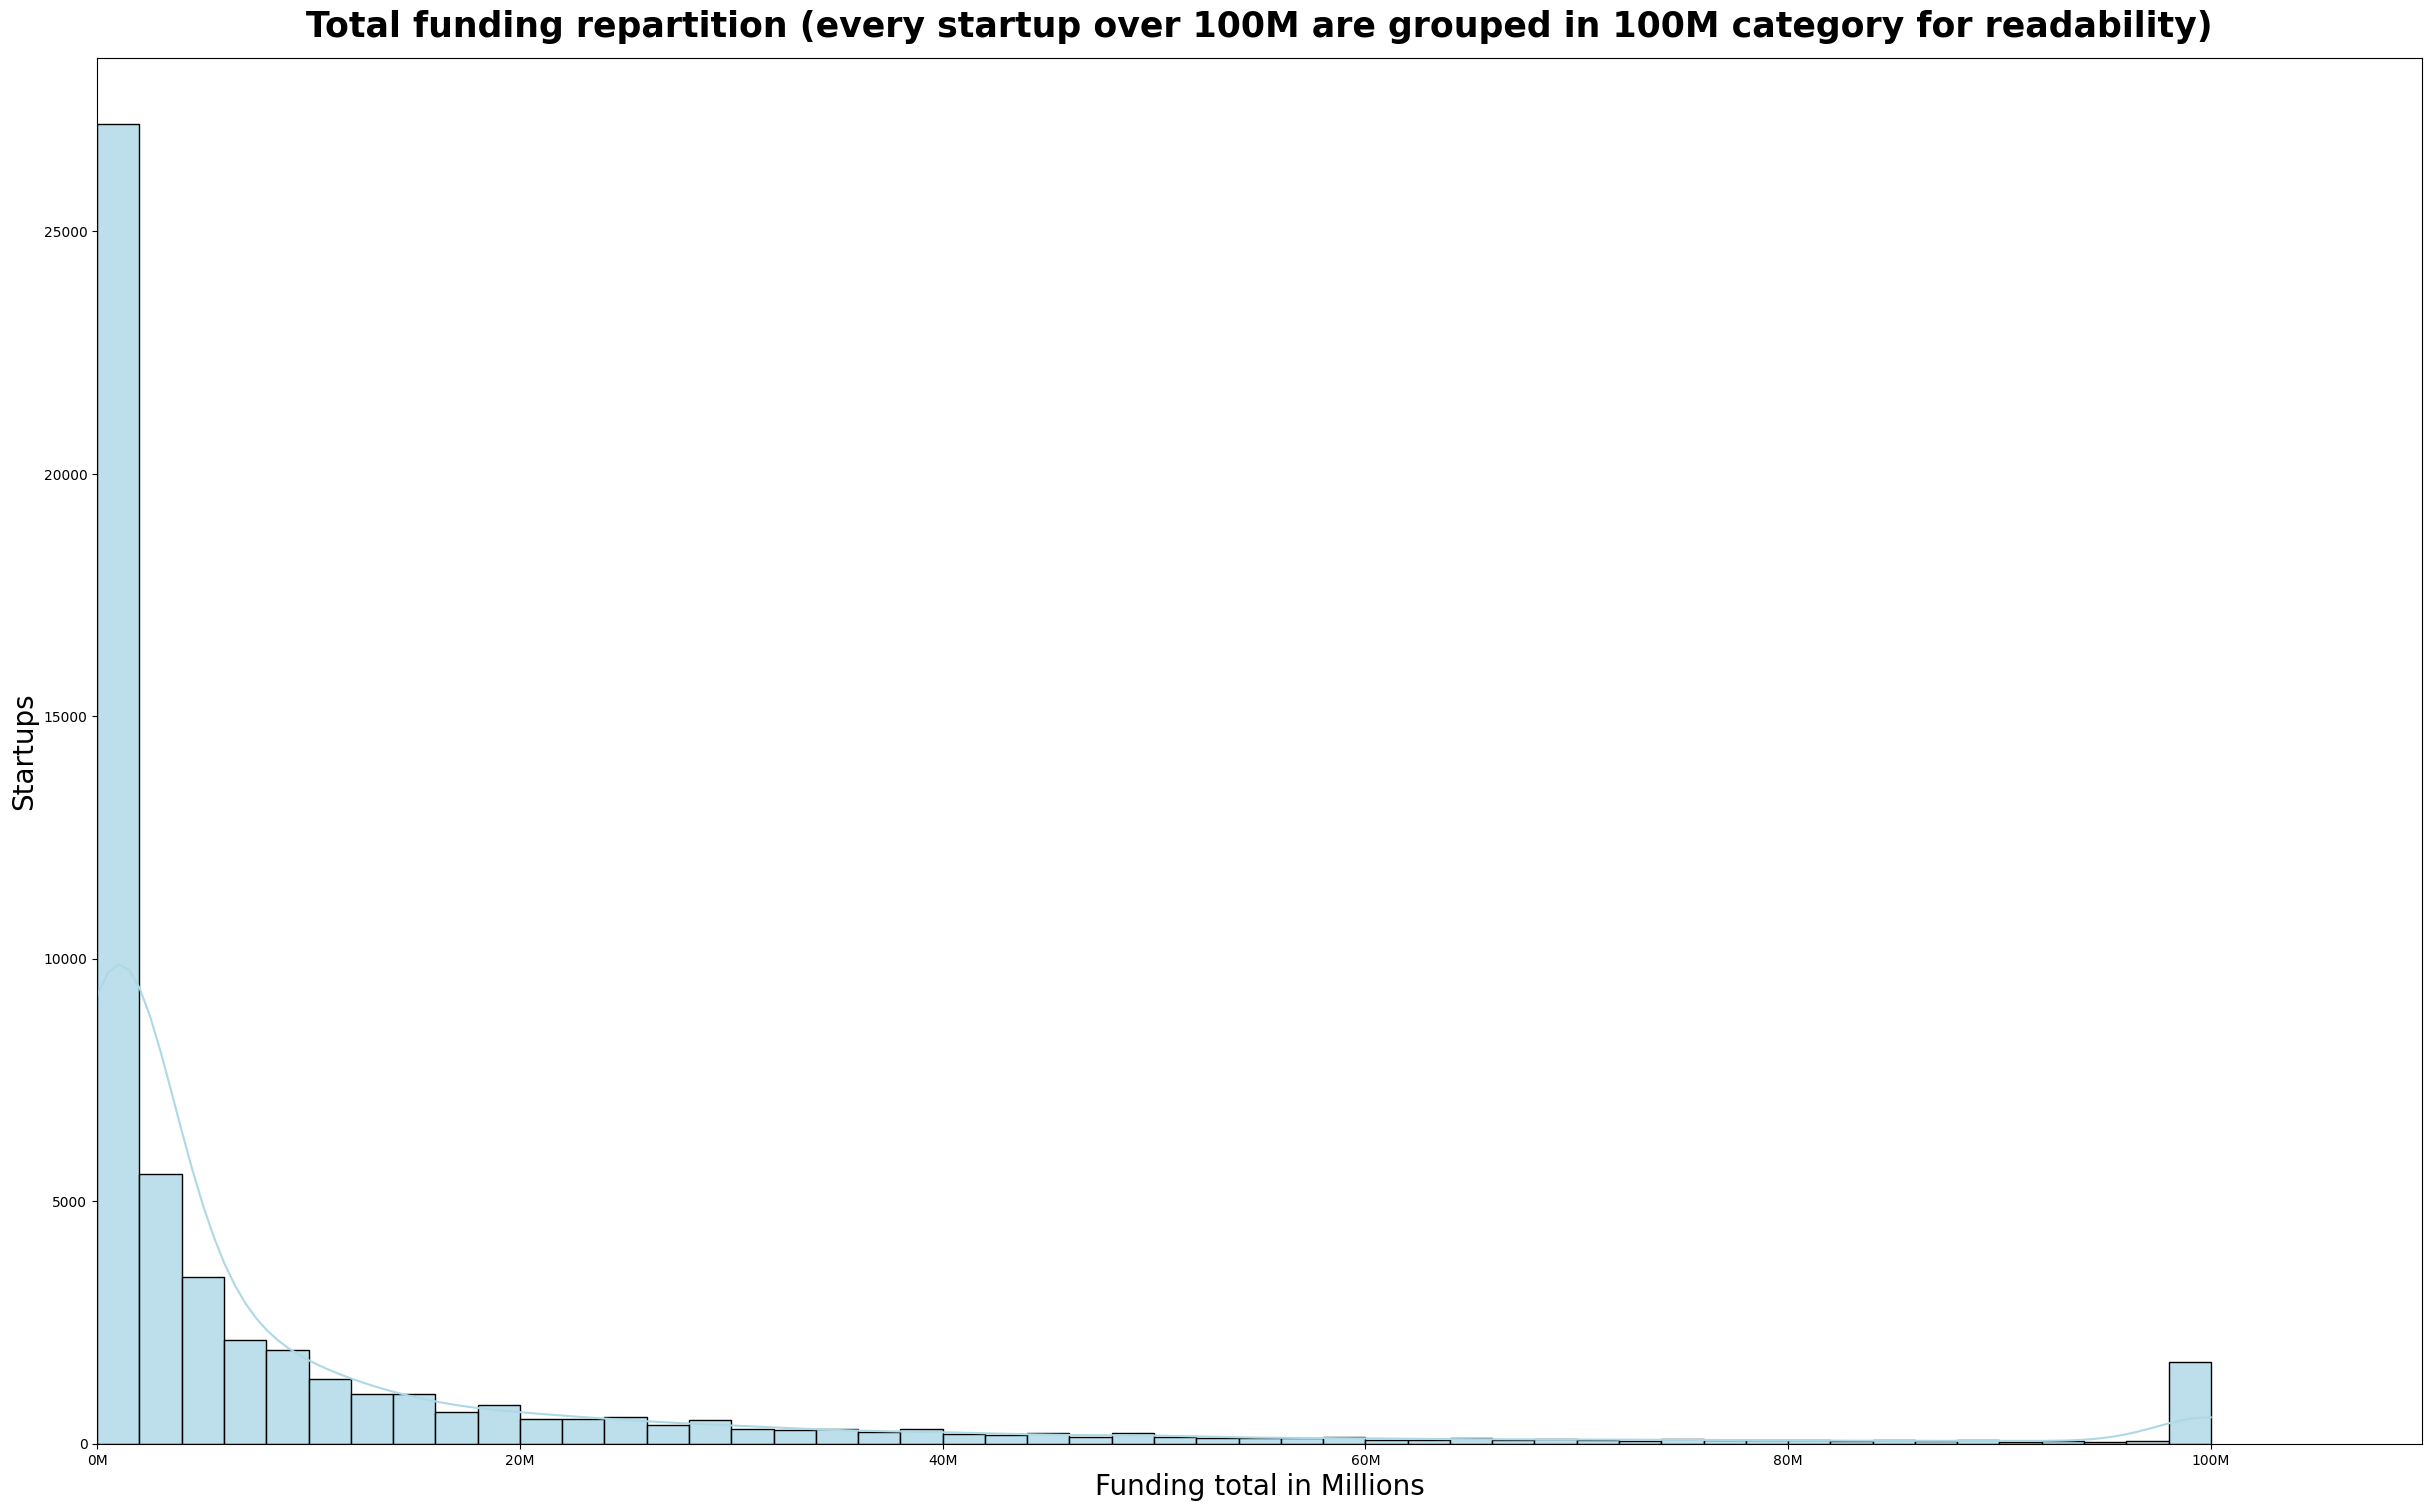

In [71]:
df["funding_total_usd"] = pd.to_numeric(df["funding_total_usd"], errors="coerce")


plt.figure(figsize=(30, 18))

# Replace values > 100M only for display purposes
sns.histplot(np.where(df["funding_total_usd"] > 100e6, 100e6, df["funding_total_usd"]),
             bins=50, kde=True, color = "lightblue", alpha = 0.8)



# Reformat the X-axis to display values in millions
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.xlim(0, 110e6)  # Define the limit to 110M
plt.xlabel("Funding total in Millions", fontsize=20)
plt.ylabel("Startups", fontsize=20)
plt.title("Total funding repartition (every startup over 100M are grouped in 100M category for readability)",fontsize=25, fontweight="bold", pad=15 )
plt.show()


This histogram represents the distribution of total funding amounts (in millions) across the startups in the dataset, with a cap at 100M for readability.

Key Observations:
1️⃣ Highly Skewed Distribution

The majority of startups have received very low funding, with a sharp decline in frequency as funding amounts increase.
This suggests that most startups in the dataset operate with limited investment, while only a few have secured substantial funding.
2️⃣ Long Tail Effect

The histogram shows a long right tail, meaning that a small number of companies have received exceptionally high funding (tens or even hundreds of millions).
This reflects a common trend in venture capital, where a few startups attract the majority of investments.
3️⃣ Clustering of Low-Funded Startups

The largest concentration of instances is near $0M to $5M, which suggests that early-stage or seed-funded startups dominate the dataset.
Most startups likely operate on small to medium-sized investments rather than large funding rounds.
4️⃣ Artificial Cap at $100M

Since startups with funding above $100M were grouped together, it’s possible that some outliers exist beyond this range.

This would be interesting to look at the distribution for the firms above 100M


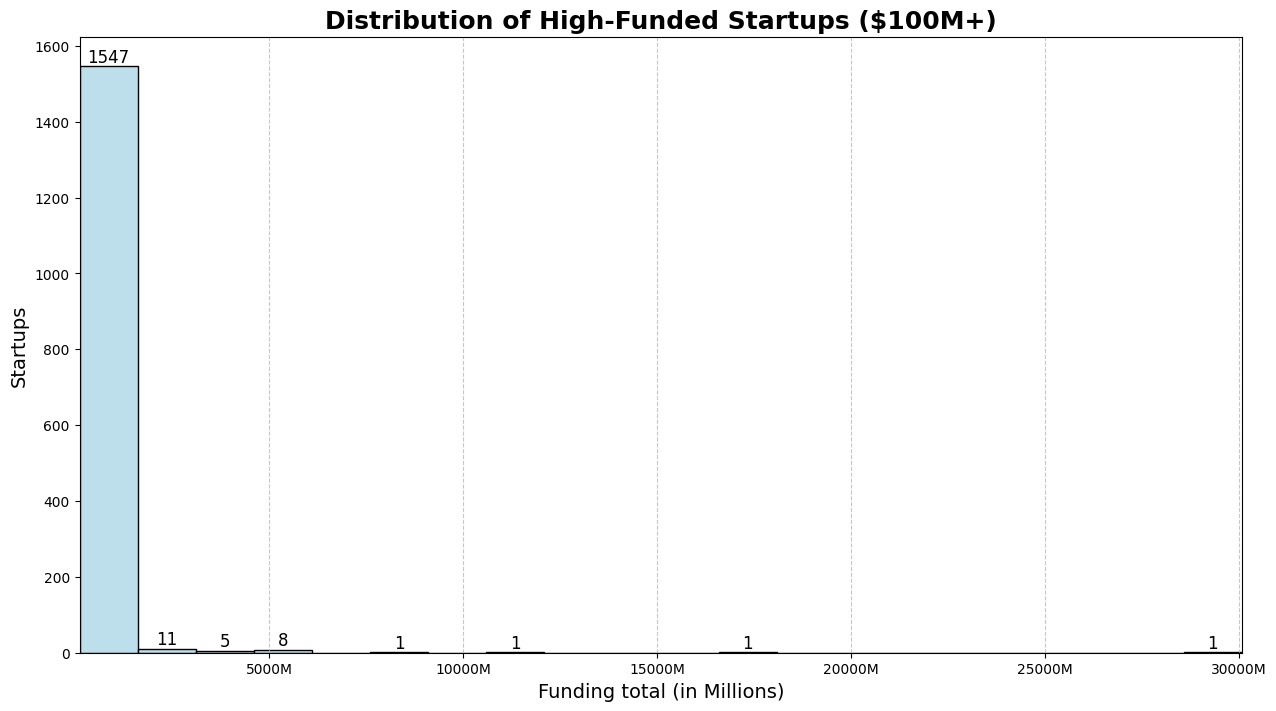

In [72]:
df_high_funding = df[df["funding_total_usd"] > 100e6]

# Plot histogram for only high-funded startups
plt.figure(figsize=(15, 8))
ax = sns.histplot(df_high_funding["funding_total_usd"], bins=20, kde=False, color="lightblue", alpha=0.8)

# Format X-axis in millions
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.xlim(100e6, df_high_funding["funding_total_usd"].max() + 10e6)  # Start at 100M

# Add value labels on bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid empty bars
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2, height),  
                    ha='center', va='bottom', fontsize=12, color="black")

# Improve chart appearance
plt.xlabel("Funding total (in Millions)", fontsize=14)
plt.ylabel("Startups", fontsize=14)
plt.title("Distribution of High-Funded Startups ($100M+)", fontsize=18, fontweight="bold")
plt.grid(axis='x', linestyle="--", alpha=0.7)

plt.show()

1️⃣ Strong Skew Toward the Lower Bound ($100M-$200M)

A majority of high-funded startups (~1,547) fall into the lowest funding bracket ($100M-$200M).
This indicates that while these companies have received substantial investment, most do not exceed $200M in funding.

2️⃣ Very Few Startups Receive Extreme Funding Amounts ($5B+)

The number of startups significantly decreases as funding increases.
Only a handful of companies have raised over $5B, and even fewer exceed $10B.
This follows a power-law distribution, where a few outliers attract massive capital investments.

This insight is even more evident when looking at boxplots 

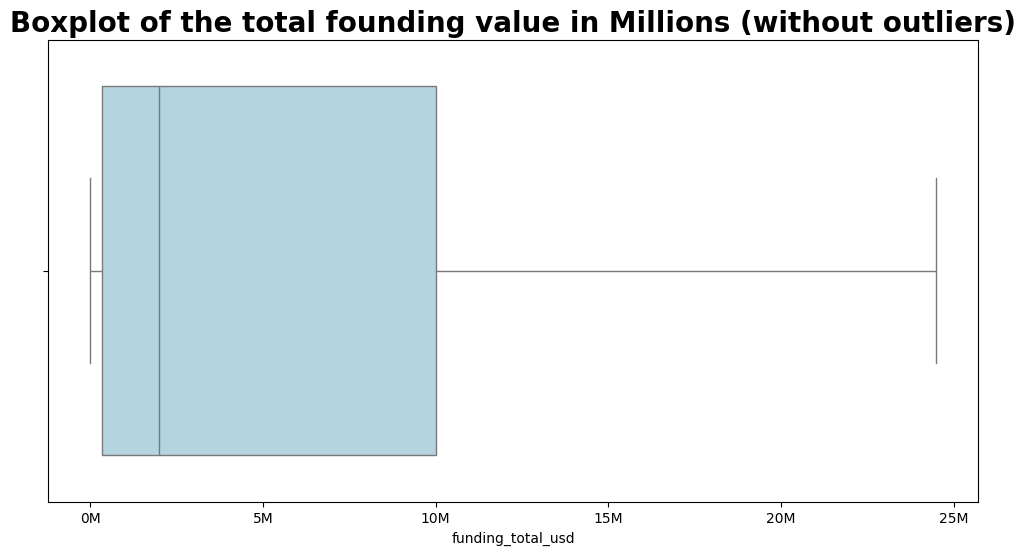

In [73]:
plt.figure(figsize=(12, 6))

# Make a boxplot without the outliers
sns.boxplot(x=df["funding_total_usd"], showfliers=False, color='lightblue')

# Transform the x axis in Millions
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

plt.title("Boxplot of the total founding value in Millions (without outliers)", fontsize = 20, fontweight="bold")

plt.show()

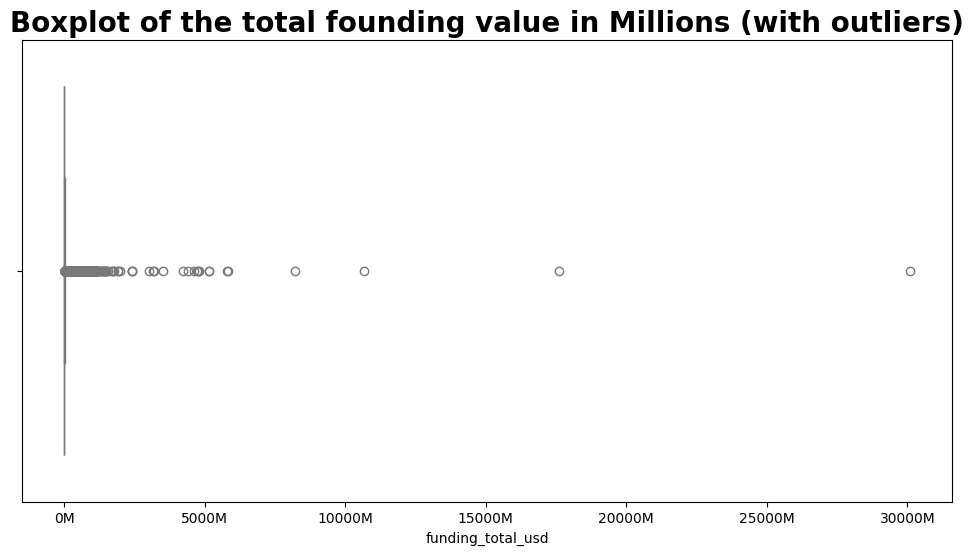

In [74]:
plt.figure(figsize=(12, 6))


sns.boxplot(x=df["funding_total_usd"], showfliers=True, color='lightblue')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))


plt.title("Boxplot of the total founding value in Millions (with outliers)", fontsize = 20, fontweight="bold")

plt.show()

The second boxplot reveal that some outliers are exceptionally extreme.

Let's now have a look at the numbers of funding rounds

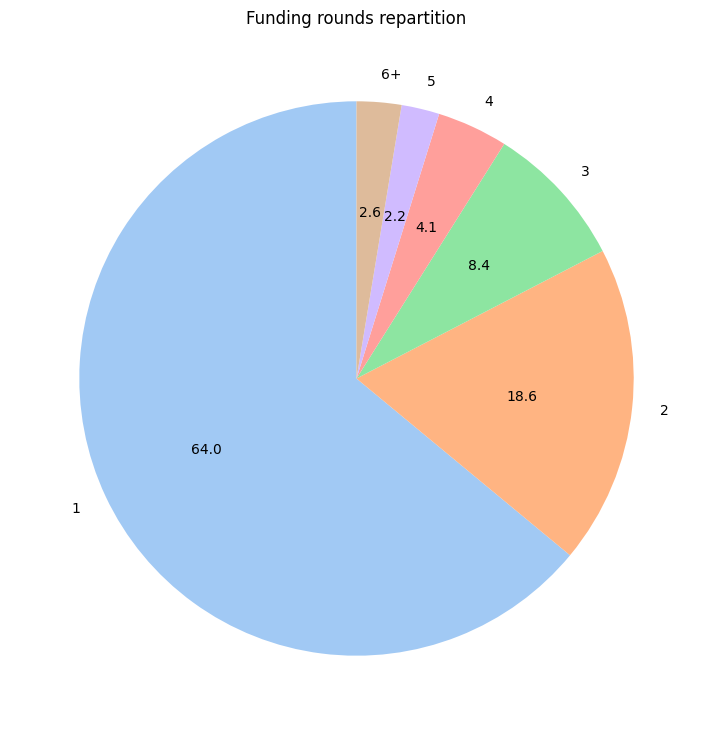

In [75]:
rounds_counts = df["funding_rounds"].value_counts()
colors = sns.color_palette("pastel", n_colors=len(rounds_counts))

# Creating a category with 6 and more for representation purpose
rounds_counts_filtered = rounds_counts[rounds_counts.index < 6] 
rounds_6_plus = rounds_counts[rounds_counts.index >= 6].sum()  
rounds_counts_filtered["6+"] = rounds_6_plus


plt.figure(figsize=(15, 9))
plt.pie(rounds_counts_filtered, labels=rounds_counts_filtered.index, autopct="%1.1f", startangle=90, colors=colors)
plt.title("Funding rounds repartition")

plt.show()

Most startups go through only one funding round, while very few manage to secure more than two rounds.

I will now focus on the years of creations and funings of the startups

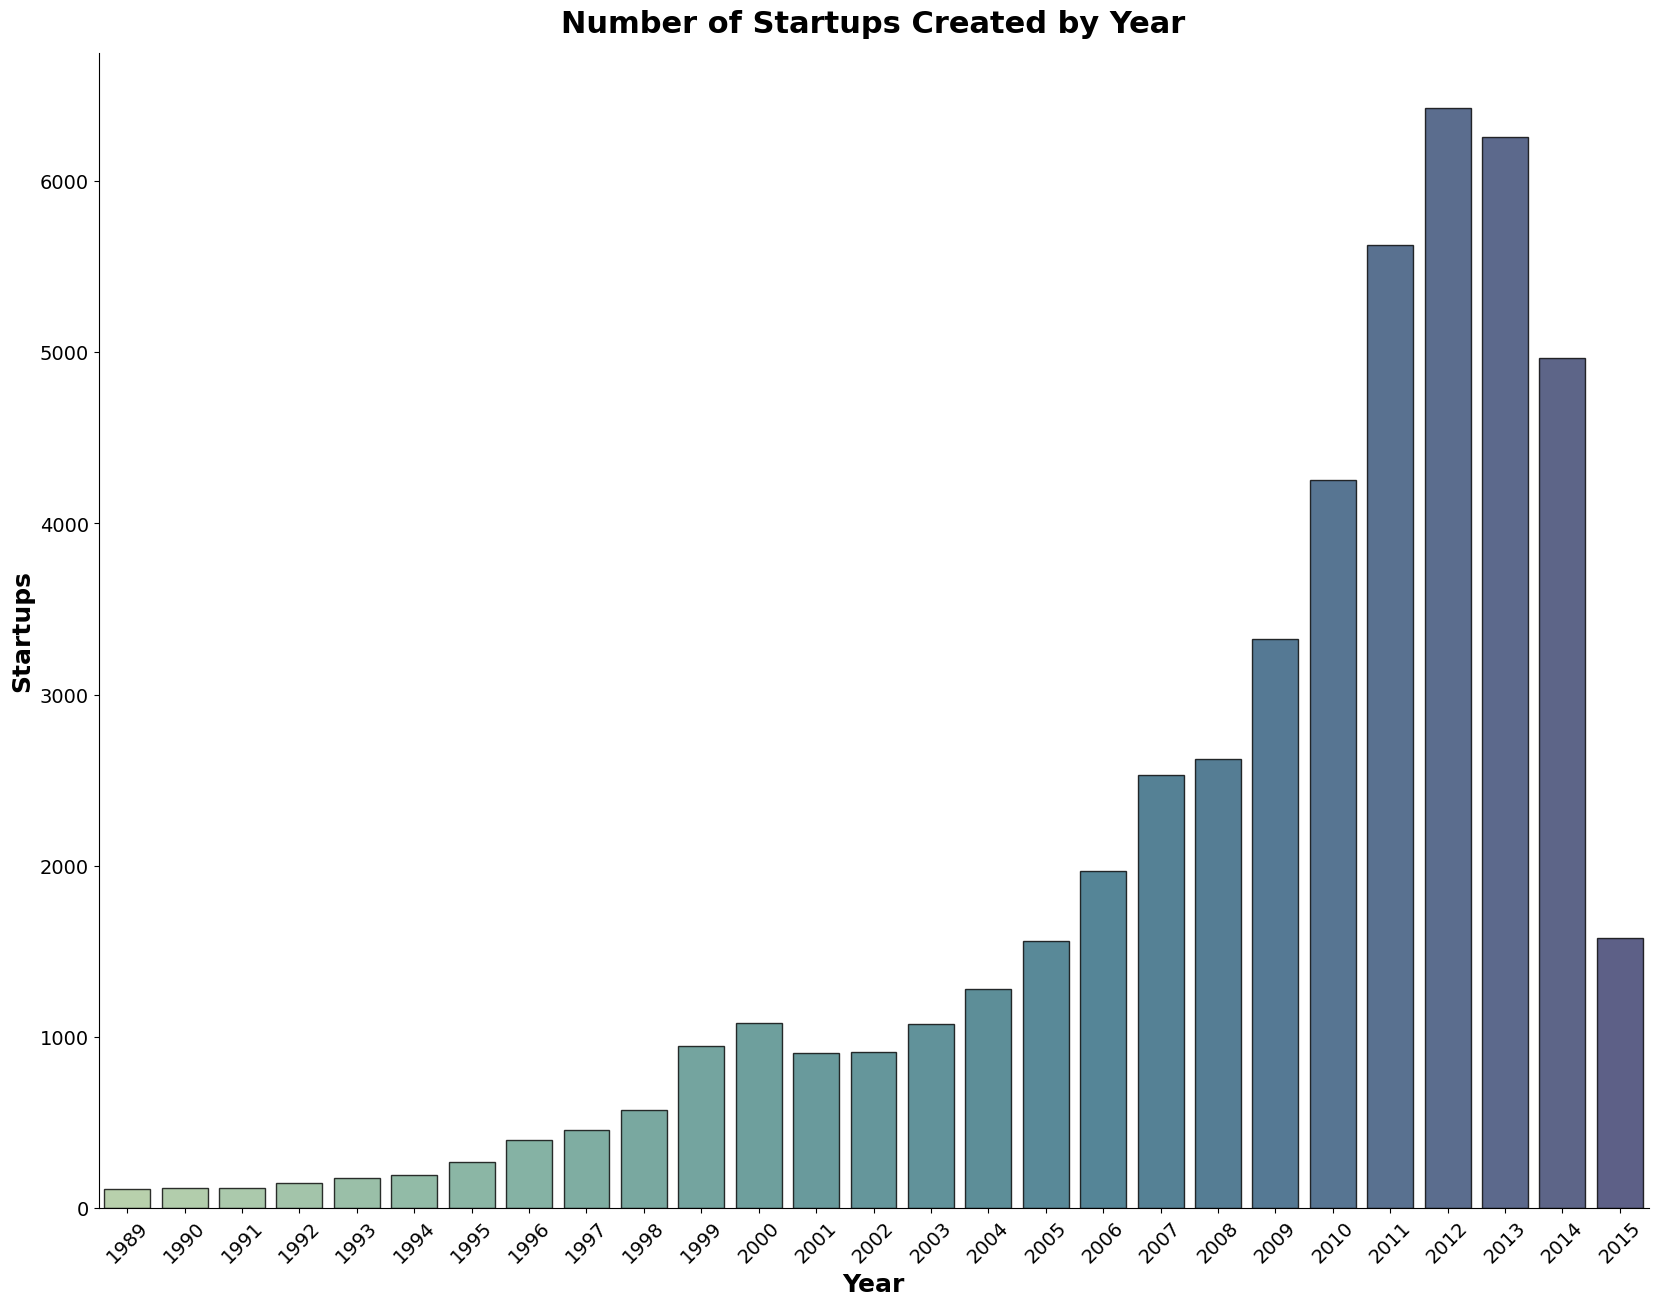

In [76]:


# Convert 'founded_at' column to datetime
df["founded_at"] = pd.to_datetime(df["founded_at"], format="%Y-%m-%d", errors="coerce")

# Count the number of startups per year and filter years with at least 100 startups
founded_at_year = df["founded_at"].dt.year.value_counts().sort_index()
founded_at_year = founded_at_year[founded_at_year >= 100]

# Ensure index is integer type
founded_at_year.index = founded_at_year.index.astype(int)

# Set figure size
plt.figure(figsize=(20, 15))

# Create bar plot
sns.barplot(
    x=founded_at_year.index, 
    y=founded_at_year.values, 
    hue=founded_at_year.index,  # Fix FutureWarning issue
    palette="crest", 
    edgecolor="black", 
    alpha=0.8,
    legend=False
)

# Titles and labels
plt.title("Number of Startups Created by Year", fontsize=22, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=18, fontweight="bold")
plt.ylabel("Startups", fontsize=18, fontweight="bold")

# Improve tick readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine()

# Show plot
plt.show()


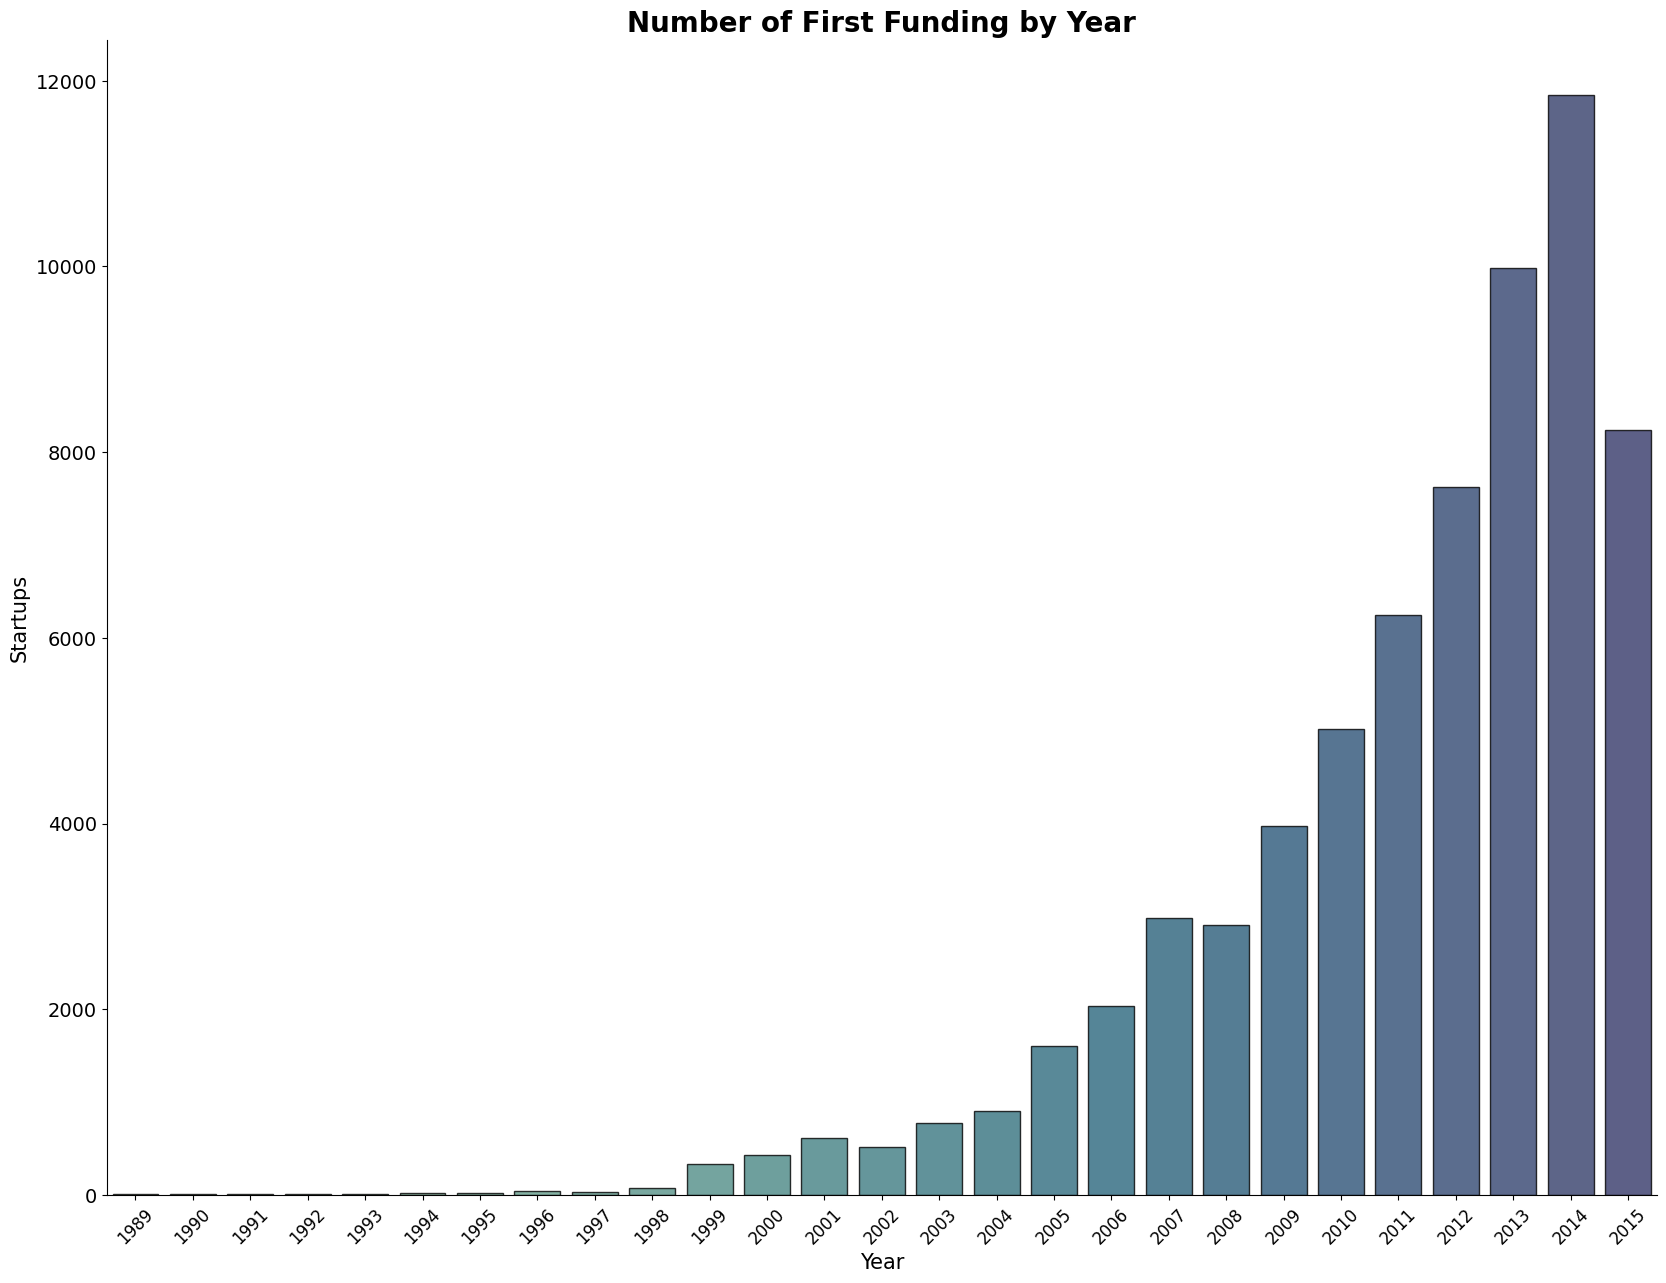

In [77]:
# Convert 'first_funding_at' to datetime, coercing errors to NaT
df["first_funding_at"] = pd.to_datetime(df["first_funding_at"], format="%Y-%m-%d", errors="coerce")

# Filter dataset for records between 1989 and 2025
df_1989 = df[(df["first_funding_at"].dt.year >= 1989) & (df["first_funding_at"].dt.year <= 2025)]

# Count occurrences of each year
first_funding_at_year = df_1989["first_funding_at"].dt.year.value_counts().sort_index()

first_funding_at_year.index = first_funding_at_year.index  

plt.figure(figsize=(20, 15))

# Bar plot of first funding events per year
sns.barplot(
    x=first_funding_at_year.index, 
    y=first_funding_at_year.values, 
    palette="crest",
    edgecolor="black", 
    alpha=0.8,
    hue=first_funding_at_year.index,  # Prevents FutureWarning in Seaborn 0.14+
    legend=False
)

# Titles and labels
plt.title("Number of First Funding by Year", fontsize=20, fontweight="bold")
plt.ylabel("Startups", fontsize=15)
plt.xlabel("Year", fontsize=15)

# Improve tick readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine()


plt.show()

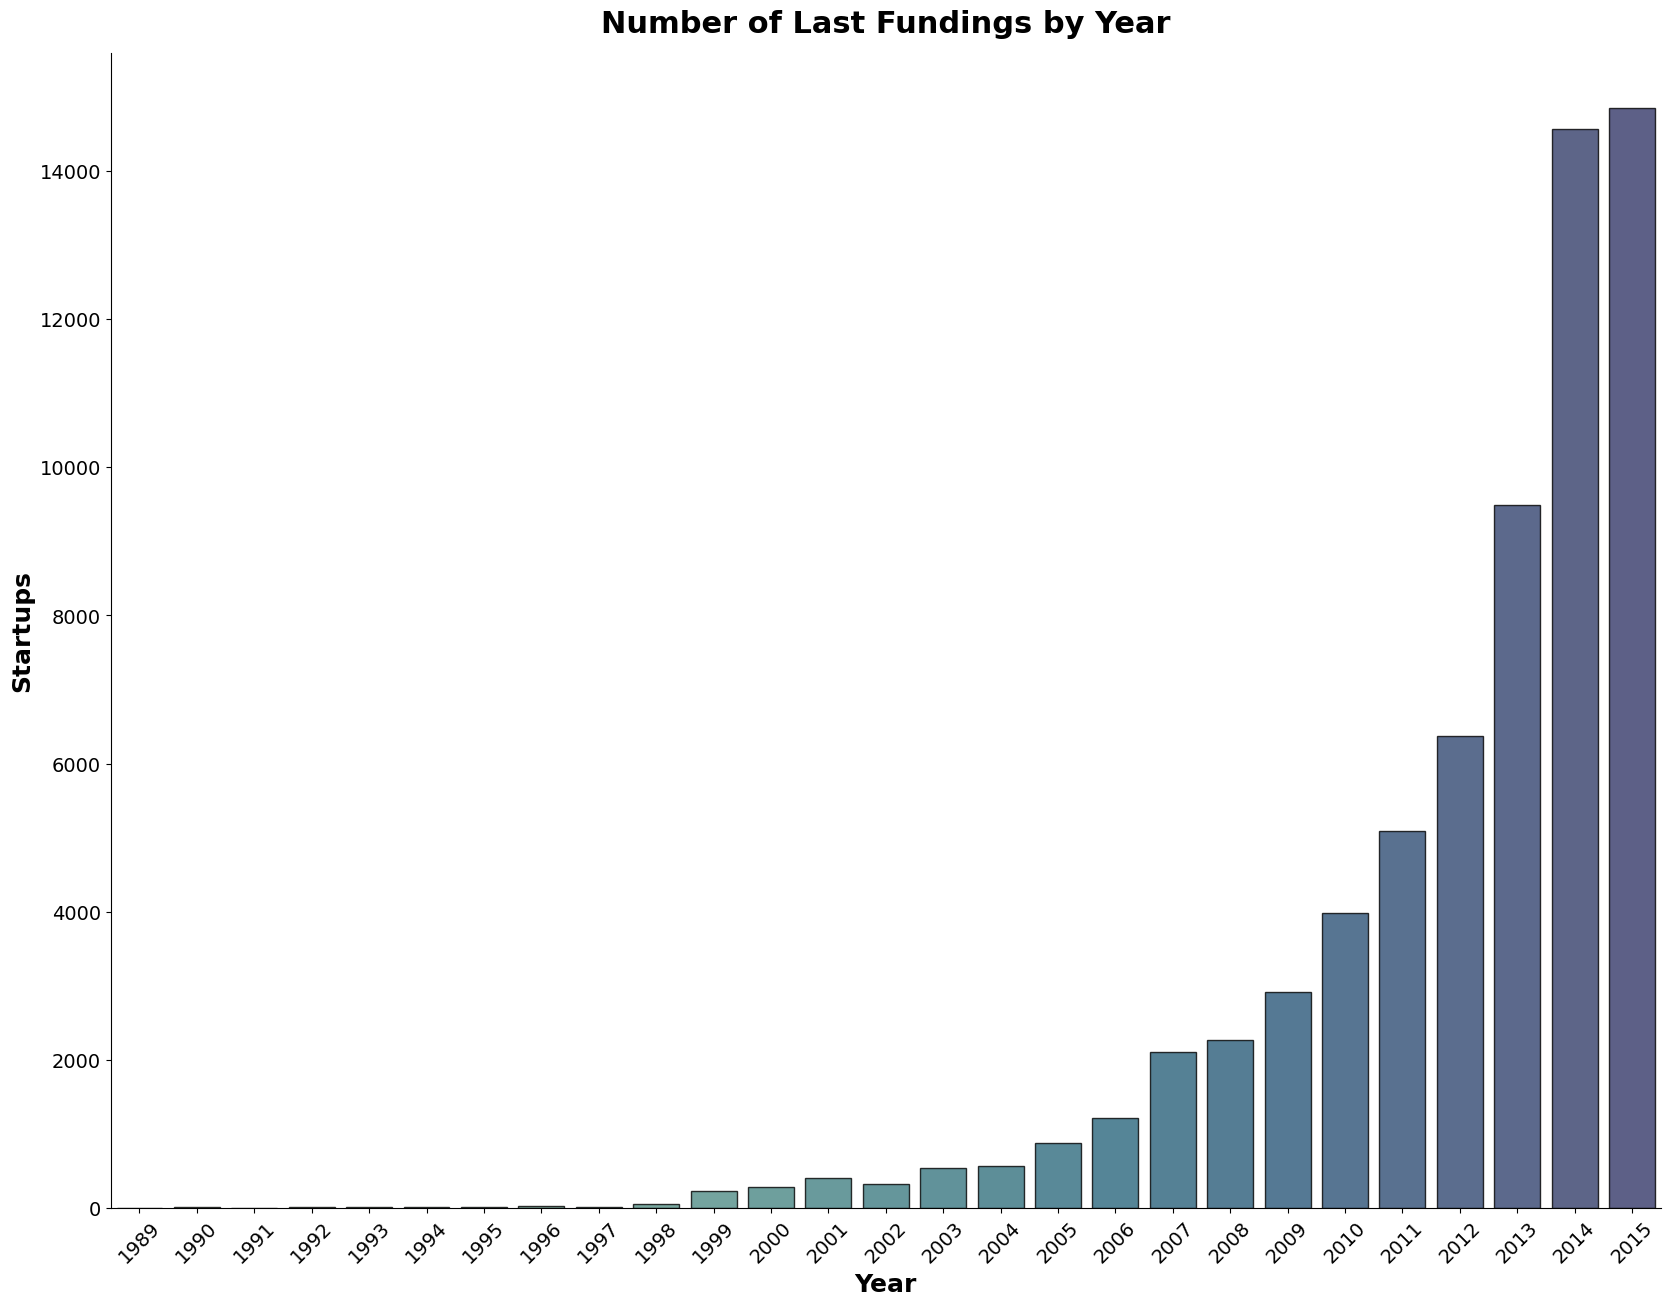

In [78]:

# Convert 'last_funding_at' to datetime properly using .loc to avoid SettingWithCopyWarning
df_1989 = df_1989.copy()  # Avoid modifying a slice of the original DataFrame
df_1989["last_funding_at"] = pd.to_datetime(df_1989["last_funding_at"], format="%Y-%m-%d", errors="coerce")

# Filter data for valid years (<= 2025)
df_1989 = df_1989[df_1989["last_funding_at"].dt.year <= 2025]

# Count the number of last fundings per year
last_funding_at_year = df_1989["last_funding_at"].dt.year.value_counts().sort_index()

# Set figure size
plt.figure(figsize=(20, 15))

# Create bar plot
sns.barplot(
    x=last_funding_at_year.index, 
    y=last_funding_at_year.values, 
    hue=last_funding_at_year.index,  # Fix FutureWarning
    palette="crest", 
    edgecolor="black", 
    alpha=0.8,
    legend=False
)

# Titles and labels
plt.title("Number of Last Fundings by Year", fontsize=22, fontweight="bold", pad=15)
plt.xlabel("Year", fontsize=18, fontweight="bold")
plt.ylabel("Startups", fontsize=18, fontweight="bold")

# Improve tick readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine()

# Show plot
plt.show()


An interesting question to explore is: Which sector has the highest survival rate?

Let's take a closer look.

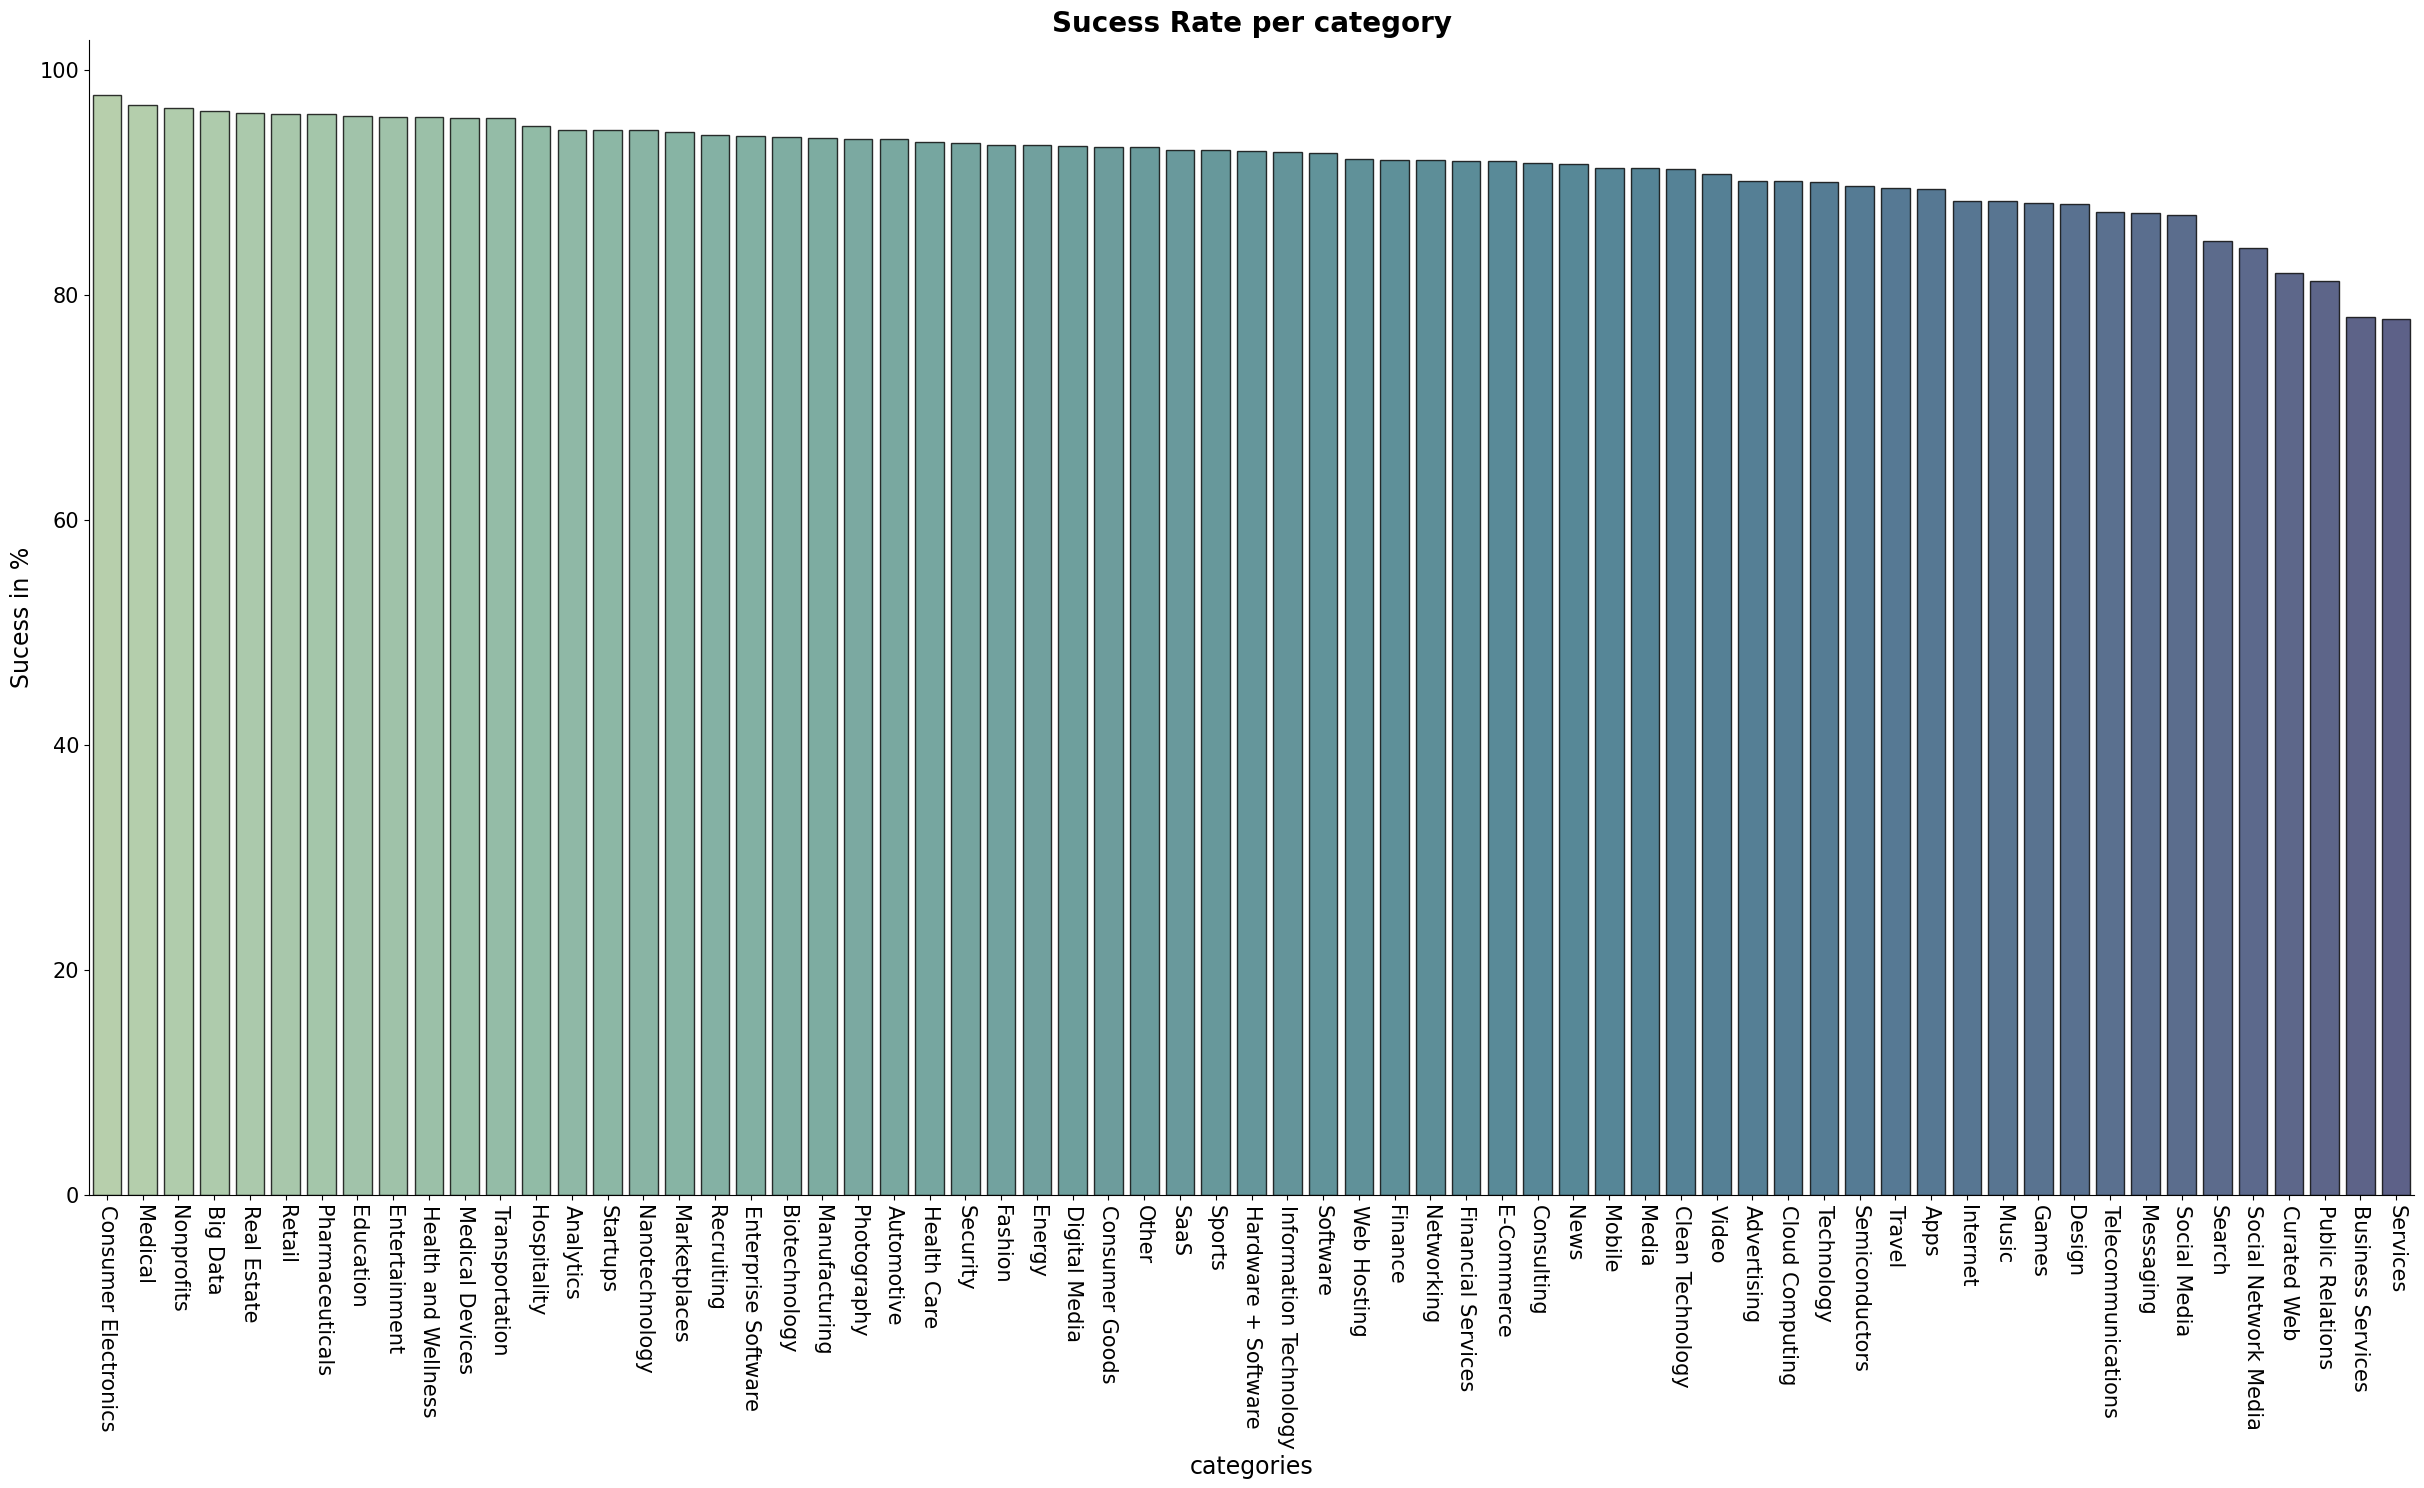

In [79]:
data = df

success = {'operating', 'ipo',"acquired"}

data['Success_bool'] = data['status'].isin(success).astype(int)

success_rate = data.groupby('category_list')['Success_bool'].mean() * 100  # En pourcentage

success_rate = success_rate.sort_values(ascending=False)

#We get rid of the Unknown category since this wouldn't give us any insight
success_rate.drop("unknown", inplace=True)

plt.figure(figsize=(30,15))
sns.barplot(
    x = success_rate.index,
    y = success_rate.values, 
    palette="crest",
    hue=success_rate.index,
    edgecolor = "black",
    alpha = 0.8,
    legend=False
)
plt.title("Sucess Rate per category", fontsize = 20, fontweight="bold")
plt.ylabel("Sucess in %", fontsize =17)
plt.xlabel("categories", fontsize = 17)
plt.xticks(rotation=-90, fontsize = 15)
plt.yticks(fontsize = 15)
sns.despine()
plt.show()

We can also see if the number of funding rounds have an impact on the survival rate

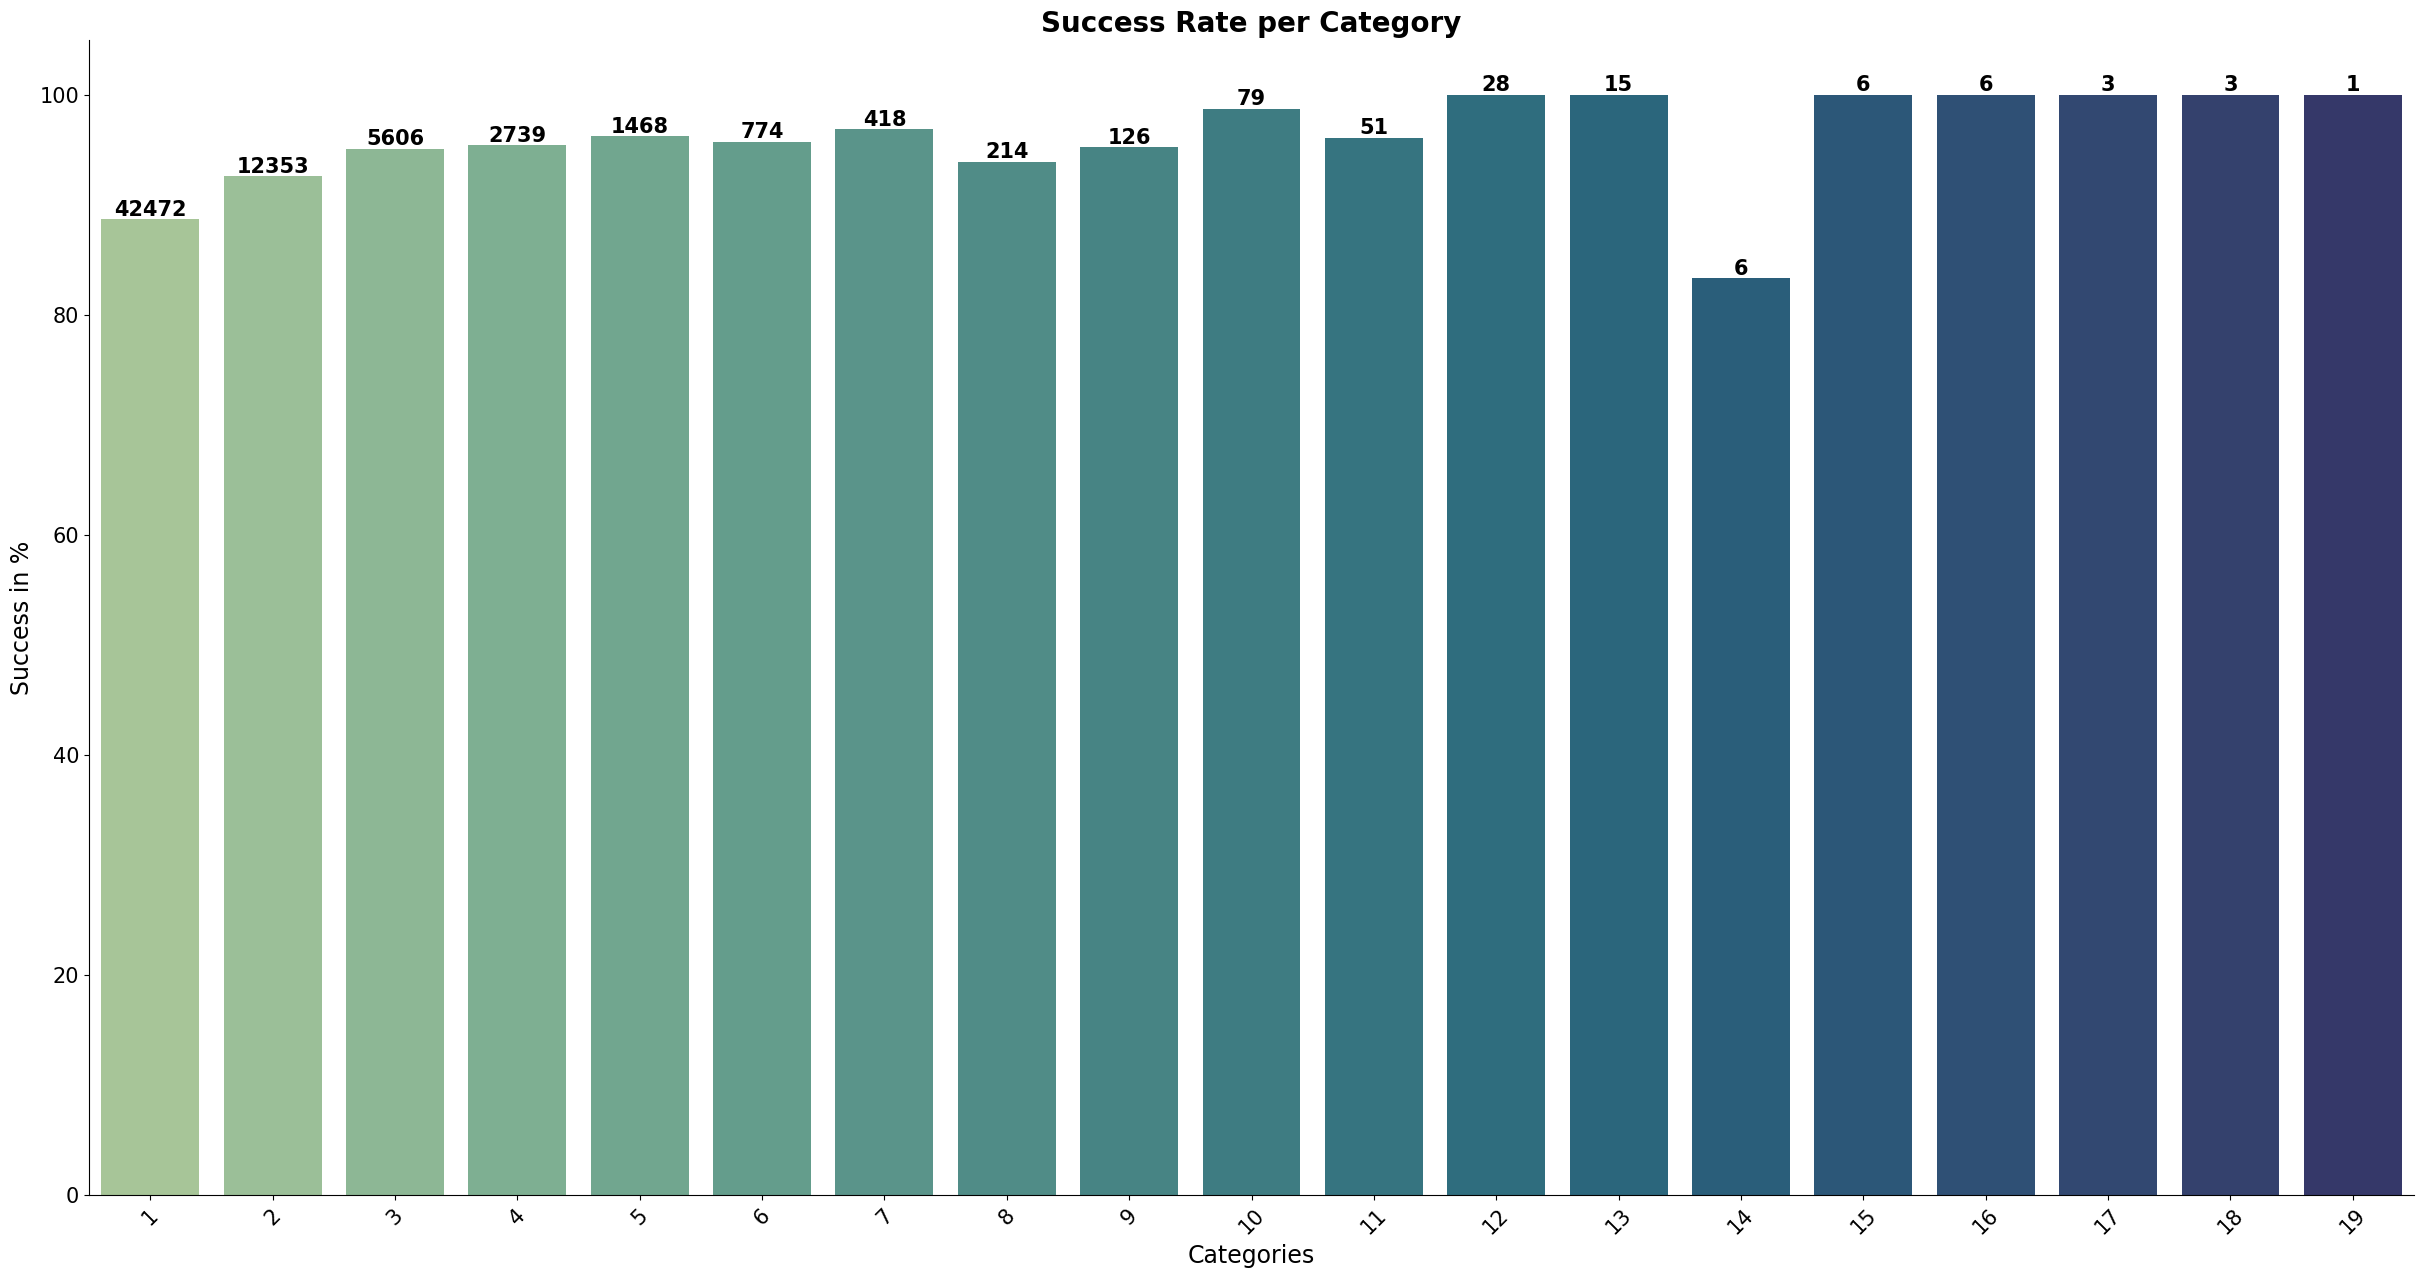

In [80]:
found_raising = data.groupby("funding_rounds")["Success_bool"].mean() * 100

numbre = data["funding_rounds"].value_counts()
numbre
numbre_values = numbre.values


plt.figure(figsize=(30,15))
ax = sns.barplot(x=found_raising.index, y=found_raising.values, palette="crest", hue=found_raising.index, legend=False)

# Adding the # of Starups in the category upside each bar
for i, bar in enumerate(ax.patches):
    ax.annotate(f"{numbre_values[i]}",  
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),  
                ha='center', va='bottom', fontsize=15, fontweight='bold')


plt.title("Success Rate per Category", fontsize=20, fontweight="bold")
plt.ylabel("Success in %", fontsize=17)
plt.xlabel("Categories", fontsize=17)
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=15)

sns.despine()
plt.show()

We see a general trend that tend to show that the number of funding rounds has a positiv impact on the survival rate. the sudden drop at 14 rounds is explained by the small number of Startups in this group, in fact only 1 has died 

Using Machine Learning to predict startup success would be an exciting challenge. However, before proceeding, it's important to recognize the limitations of our dataset.

While we have a wealth of descriptive data, it lacks deeper insights into the actual factors driving success or failure. In other words, there may not be a strong correlation between our predictors and the outcome variable, which could make accurate predictions difficult.

I will start by creating a usable DataFrame to be used by a RandomForest

In [81]:


# Copy the DataFrame to avoid modifying the original
df_final = df.drop(columns="Success_bool").copy()

# Encoding the "status" column
label_encoder = LabelEncoder()
df_final["status"] = label_encoder.fit_transform(df_final["status"])

# Encoding countries with a minimum occurrence threshold
threshold = 10
country_counts = df["country_code"].value_counts()
df_final["country_code"] = df_final["country_code"].apply(lambda x: x if country_counts.get(x, 0) > threshold else "Other")

# Label encoding for categorical columns
df_final["country_code"] = label_encoder.fit_transform(df_final["country_code"])
df_final["category_list"] = label_encoder.fit_transform(df_final["category_list"])

# Convert date columns to year format
date_columns = ["last_funding_at", "first_funding_at", "founded_at"]
for col in date_columns:
    df_final[col] = pd.to_datetime(df_final[col], format="%Y-%m-%d", errors="coerce").dt.year.astype("Int64")

# Replacing missing values with the median using .loc to avoid FutureWarning
for col in date_columns:
    df_final.loc[:, col] = df_final[col].fillna(df_final[col].median())

# Validate and convert funding_total_usd column
df_final["funding_total_usd"] = pd.to_numeric(df_final["funding_total_usd"], errors="coerce")

# Drop rows where funding_total_usd is NaN
df_final.dropna(subset=["funding_total_usd"], inplace=True)

# Removing outliers from funding_total_usd
df_final["funding_total_usd"] = df_final["funding_total_usd"].clip(
    lower=df_final["funding_total_usd"].quantile(0.01),
    upper=df_final["funding_total_usd"].quantile(0.99)
)



In [82]:
X = df_final.drop(columns="status")
y = df_final["status"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100,class_weight="balanced" ,random_state=42)

# Model Training
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [83]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  

print(f"R² Score : {r2:.2f}")
print(f"MSE : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")

R² Score : -0.25
MSE : 1.21
RMSE : 1.10


As I thought, the results are really poor, let's see the correlation matrix to try to understand better

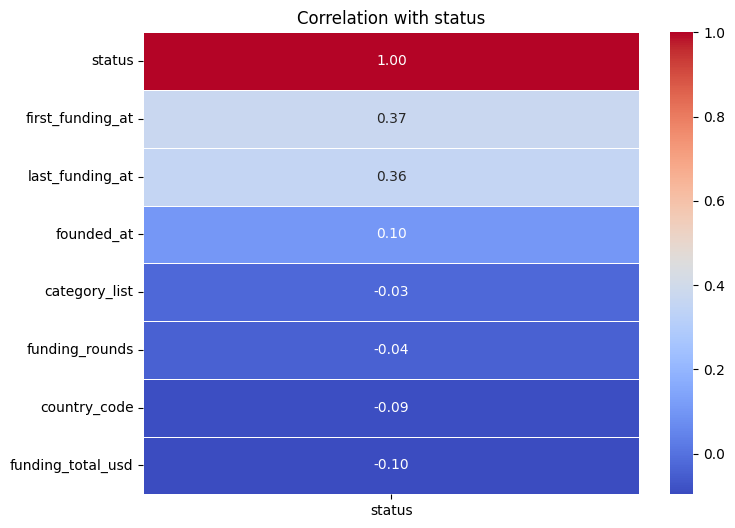

In [84]:


# Compute correlation matrix
corr = df_final.corr()

# Select only one column, e.g., "funding_total_usd"
column_corr = corr["status"].sort_values(ascending=False)  # Sort by strength

# Display as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(column_corr.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation with status")
plt.show()


Indeed, there is no strong correlation between a startup's status and any of the available data. The only variables showing a slight correlation are the first and last funding years, suggesting that the overall state of the economy plays a role in startup survival rates.